In [1]:
import sys
import os

# Usar el directorio de trabajo actual en lugar de __file__
path = os.getcwd()
sys.path.insert(0, os.path.join(path, '..', 'src'))

import data_preparation as dp
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'..\data\raw\base_train.csv',sep='|', encoding='utf-8')
import data_preparation as dp


cleaner = dp.DataCleaner()
df = cleaner.clean(df)

 Justificación (en una línea):
Se aplica undersampling 3:1 para reducir el sesgo del modelo hacia la clase mayoritaria, manteniendo suficiente información real sin crear datos sintéticos.

# Feature selection

## rebalanceo de datos

In [3]:
from sklearn.utils import resample

# Separar las clases
df_majority = df[df['default'] == 0]
df_minority = df[df['default'] == 1]

# Submuestreo de la clase mayoritaria a una proporción 3:1 respecto a la clase positiva
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=3 * len(df_minority),
    random_state=42
)

# Combinar el nuevo dataset balanceado
df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42)  # Mezclar filas

df_balanced['default'].value_counts()

default
0    5676
1    1892
Name: count, dtype: int64

## preprocesamiento

In [10]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Separación de variables numéricas y categóricas
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['default'], errors='ignore').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Limpieza previa de infinitos solo en numéricas
df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)

# Preprocesamiento para variables numéricas
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocesamiento para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer que aplica los pipelines por tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Separar variable objetivo
y = df['default']
X = df.drop(columns=['default'], errors='ignore')

# Aplicar preprocesamiento
X_preprocessed = preprocessor.fit_transform(X)

# Obtener nombres de columnas generadas por OneHotEncoder
ohe_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
processed_columns = numerical_cols + ohe_columns.tolist()

# Convertir a DataFrame final
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=processed_columns)

# Validación (opcional)
print(f"✅ Shape final: {X_preprocessed_df.shape}")


✅ Shape final: (28098, 88)


## eliminacion variables altamente correlacioandas

In [12]:
# Extrae solo las columnas numéricas excluyendo 'default'
X_numeric = X_preprocessed_df.select_dtypes(include=[np.number])

# Calcula la matriz de correlación absoluta
corr_matrix = X_numeric.corr().abs()

# Parte superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Variables con correlación > 0.9
threshold_corr = 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] > threshold_corr)]

# Elimina las columnas correlacionadas del conjunto original
X_corr_filtered = X_numeric.drop(columns=to_drop_corr)

print(f"Variables eliminadas por correlación alta ({threshold_corr}):\n{to_drop_corr}")
# dataframe con las correlaciones
# Generamos el dataframe de pares: variable 1, variable 2 y la correlación entre ambas
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'correlation'})
)
corr_pairs['abs_correlation'] = corr_pairs['correlation'].abs()

corr_pairs[corr_pairs['abs_correlation'] > 0.8].sort_values(by='abs_correlation', ascending=False).head(10)


Variables eliminadas por correlación alta (0.8):
['trx158', 'CO01END094RO', 'CO01ACP011RO', 'antiguedad_dif_telcos', 'antiguedad_dif_ahorro_rot', 'utilizacion_actual', 'variacion_saldo_9m', 'relacion_saldo_cupo', 'log_trx39', 'log_trx102', 'log_trx106', 'log_trx143', 'log_trx158', 'log_CO01END010RO', 'log_CO01ACP017CC', 'log_CO02EXP011TO', 'log_CO02EXP004TO', 'log_CO01END094RO', 'log_CO01EXP002AH', 'log_CO01END051RO', 'log_CO01ACP011RO', 'log_relacion_saldo_cupo', 'log_utilizacion_actual', 'log_delta_trx_mes', 'log_CO02END015CC_imputado', 'log_variacion_saldo_9m_imputado', 'log_CO01ACP011RO_imputado', 'log_CO01END094RO_imputado', 'log_CO01EXP003RO_imputado', 'CO01NUM002AH_medio', 'CO02MOR092TO_desconocido', 'CO01MOR098RO_desconocido', 'util_cat_alta', 'util_cat_baja', 'mora_rot_cat_desconocido', 'mora_rot_cat_mala', 'mora_total_cat_desconocido', 'mora_total_cat_mala', 'var_saldo_cat_mejora']


,var1,var2,correlation,abs_correlation
3735,mora_total_cat_desconocido,mora_total_cat_mala,1.000000,1.000000
3740,var_saldo_cat_deterioro,var_saldo_cat_mejora,1.000000,1.000000
199,trx106,log_trx106,1.000000,1.000000
114,trx102,log_trx102,1.000000,1.000000
3720,mora_rot_cat_desconocido,mora_rot_cat_mala,0.999572,0.999572
366,trx158,log_trx158,0.999405,0.999405
1934,delta_trx_mes,log_delta_trx_mes,0.998666,0.998666
283,trx143,log_trx143,0.998615,0.998615
749,CO01EXP001CC,antiguedad_dif_telcos,0.997035,0.997035
3680,CO01MOR098RO_desconocido,mora_rot_cat_mala,0.996790,0.996790


Se eliminaron las variables trx158, CO01END094RO y CO01ACP011RO por presentar alta correlación (> 0.8) con otras variables (trx39, CO01END010RO, y CO02NUM043RO respectivamente). Esta eliminación se realizó para evitar redundancia de información, reducir la multicolinealidad y mejorar la estabilidad e interpretabilidad del modelo, en línea con buenas prácticas analíticas e IFRS 9. Se conservaron las variables con mayor representatividad y cobertura de datos.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Escala los datos antes de calcular VIF (mejor estabilidad numérica)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr_filtered)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_corr_filtered.columns)

# Iterativamente elimina variables con VIF alto
threshold_vif = 10
vif_data = pd.DataFrame()
features = list(X_scaled_df.columns)

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X_scaled_df[features].values, i) for i in range(len(features))]

    max_vif = vif_data["VIF"].max()
    if max_vif > threshold_vif:
        drop_feat = vif_data.sort_values(by="VIF", ascending=False).iloc[0]["feature"]
        print(f"Eliminando por VIF alto: {drop_feat} (VIF={max_vif:.2f})")
        features.remove(drop_feat)
    else:
        break

X_vif_filtered = X_scaled_df[features]
if len(features) < X_corr_filtered.shape[1]:
    print(f"Variables eliminadas por VIF alto (> {threshold_vif}):\n{set(X_corr_filtered.columns) - set(features)}")
else:
    print("No se eliminaron variables por VIF alto.")

Eliminando por VIF alto: disp309_alto (VIF=inf)
Eliminando por VIF alto: CO01END002RO (VIF=29.92)
Eliminando por VIF alto: CO01EXP003RO (VIF=11.17)
Variables eliminadas por VIF alto (> 10):
{'CO01END002RO', 'CO01EXP003RO', 'disp309_alto'}


Variables seleccionadas con Lasso:
['trx39', 'trx102', 'trx106', 'CO01END010RO', 'CO02EXP011TO', 'CO02EXP004TO', 'CO02END015CC', 'CO01END086RO', 'CO02NUM086AH', 'CO02NUM043RO', 'CO01EXP002AH', 'mes', 'bandera_riesgo_1', 'log_CO01END002RO', 'log_CO01END086RO', 'log_CO01END051RO_imputado', 'log_CO01END086RO_imputado', 'disp309_bajo', 'disp309_desconocido', 'CO01NUM002AH_alto', 'CO01NUM002AH_bajo', 'CO02MOR092TO_alto', 'CO02MOR092TO_bajo', 'CO02MOR092TO_medio', 'CO01MOR098RO_bajo', 'CO01MOR098RO_medio']


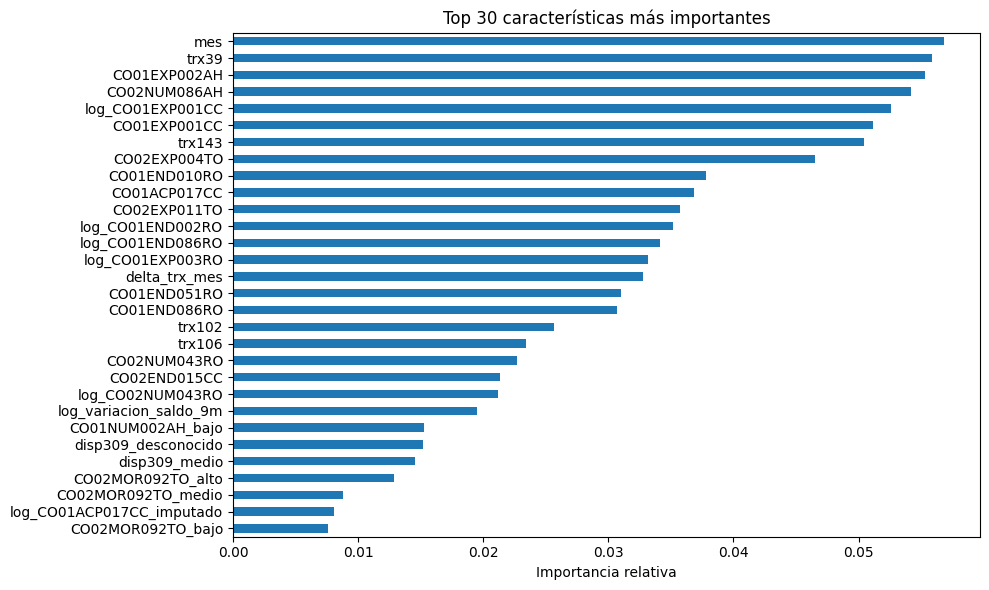

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Supongamos que y ya está definido como variable objetivo
y = df['default']

# Entrena Lasso con penalización L1
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
lasso_model.fit(X_vif_filtered, y)

# Selecciona variables con coeficientes distintos de cero
selector = SelectFromModel(lasso_model, prefit=True)
X_lasso_selected = X_vif_filtered.loc[:, selector.get_support()]

print(f"Variables seleccionadas con Lasso:\n{list(X_lasso_selected.columns)}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Suponemos que ya tienes X_vif_filtered y y
X_train, X_test, y_train, y_test = train_test_split(X_vif_filtered, y, test_size=0.3, random_state=42)

# Entrenamos un Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtenemos las importancias de características
importances = pd.Series(rf.feature_importances_, index=X_vif_filtered.columns)
importances_sorted = importances.sort_values(ascending=False)

# Seleccionamos el top 20% más importante

top_features = importances_sorted.head(30)

# Gráfico
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title(f'Top {30} características más importantes')
plt.xlabel('Importancia relativa')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [15]:
# exportar características seleccionadas
selected_features = top_features.index.tolist()
output_path = r'..\data\processed\selected_features.csv'
selected_features_df = pd.DataFrame(selected_features, columns=['feature'])
selected_features_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"Características seleccionadas exportadas a {output_path}")

Características seleccionadas exportadas a ..\data\processed\selected_features.csv
